## 1. Setup and Configuration

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import wandb

# Initialize wandb with your desired configuration
wandb.init(project="pipefishes-rl", config={
    "learning_rate": 0.001038,
    "gamma": 1.508,
    "epsilon_start": 1.889,
    "epsilon_min": 0.0104,
    "epsilon_decay": 1.401,
    "batch_size": 79,
    "episodes": 9652
})



# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: diptosen2017 (diptosen2017-svkm-s-narsee-monjee-institute-of-managemen) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Running on: cuda


In [4]:
data=r"G:\My Drive\MPSTME\SEM VI\Intelligent Systems - II\Projects\pipefishes_rl.xlsx"

In [5]:
data = pd.read_excel(data)
data

,Sex,Length,Brain_weight,Species_Corythoichthys intestinalis,Species_Doriyichthys boaja,Species_Doriyichthys martensi,Species_Doryhampus dactyliophorus,Species_Doryrhamphus japonicus,Species_Entelurus aequoreus,Species_Hippichthys penicillus,...,Location_Marshall,Location_Micronesia,Location_Miyakejima (Japan),Location_Okinawa (Japan),Location_Otsuchi bay (Japan),Location_Portugal,Location_Surugawan (Japan),Location_Sweden,Location_Taiwan,Location_Tokushima (Japan)
0,f,112.6,3.27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,f,115.0,3.97,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,f,121.4,4.83,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,f,122.4,4.09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,f,128.0,4.29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,f,173.0,3.60,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
275,f,219.0,4.50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
276,f,309.5,7.50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
277,f,237.0,3.70,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## 2. Model Architecture (Multi-Head DQN)

In [9]:
# Multi-headed DQN that outputs separate Q-values for species, location, and sex.
class MultiHeadDQN(nn.Module):
    def __init__(self, input_size, n_species, n_location, n_sex):
        super(MultiHeadDQN, self).__init__()
        hidden_size = 64
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, 32)
        self.dropout2 = nn.Dropout(0.2)
        # Separate heads:
        self.species_head = nn.Linear(32, n_species)
        self.location_head = nn.Linear(32, n_location)
        self.sex_head = nn.Linear(32, n_sex)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        q_species = self.species_head(x)
        q_location = self.location_head(x)
        q_sex = self.sex_head(x)
        return q_species, q_location, q_sex

1.  **MultiHead Deep Q-Network (MHDQN):**
    * Instead of a single output (as in a typical DQN), this network has three separate heads:
        * `species_head`: Predicts Q-values for all possible species.
        * `location_head`: Predicts Q-values for all possible locations.
        * `sex_head`: Predicts Q-values for two possible sexes (male/female).

2.  **Architecture**
    * `fc1` → `dropout1` → `fc2` → `dropout2` → (three heads).
    * Each head's output shape matches the dimension of that prediction space.
        * For example, `species_head` might have 17 outputs if there are 17 species.
        * `location_head` might have 15 outputs if there are 15 locations.
        * `sex_head` has 2 outputs for the binary sex classification.
    * `dropout` is used to reduce overfitting.

3.  **Input size:**
    * Typically 2 (Length, Brain Weight).

4.  **Return values:**
    * `q_species`, `q_location`, `q_sex`: Each is a tensor of shape `[batch_size, num_actions_for_head]`.

## 3. Experience Replay: Dataset and Collate Function

In [10]:
# Define an ExperienceDataset for replay memory
class ExperienceDataset(Dataset):
    def __init__(self, memory):
        self.memory = memory
        
    def __len__(self):
        return len(self.memory)
    
    def __getitem__(self, index):
        return self.memory[index]

def collate_fn(batch):
    states = np.concatenate([exp[0] for exp in batch], axis=0)
    act_spec = np.array([exp[1][0] for exp in batch])
    act_loc = np.array([exp[1][1] for exp in batch])
    act_sex = np.array([exp[1][2] for exp in batch])
    rew_spec = np.array([exp[2][0] for exp in batch])
    rew_loc = np.array([exp[2][1] for exp in batch])
    rew_sex = np.array([exp[2][2] for exp in batch])
    next_states = np.concatenate([exp[3] for exp in batch], axis=0)
    dones = np.array([exp[4] for exp in batch])
    return states, act_spec, act_loc, act_sex, rew_spec, rew_loc, rew_sex, next_states, dones

**1. `ExperienceDataset`:**
- Wraps our memory (list of experiences) into a `Dataset`.
- Each experience is `(state, (act_spec, act_loc, act_sex), (rew_spec, rew_loc, rew_sex), next_state, done)`.

**2. `collate_fn`:**
- organizes a batch of experiences into arrays/Tensors for training:
  - `states`, `next_states` get concatenated.
  - Action arrays `act_*`, reward arrays `rew_*`, plus a `dones` array indicating episode termination.

## 4. SeahorseRLAgent Class

In [11]:
# Define the RL Agent
class SeahorseRLAgent:
    def __init__(self, data):
        # Prepare state features
        self.X = data[['Length', 'Brain_weight']].values
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)
        
        # Define column names (ensure these match your dataset)
        self.species_columns = [
            "Species_Corythoichthys intestinalis", "Species_Doriyichthys boaja",
            "Species_Doriyichthys martensi", "Species_Doryhampus dactyliophorus",
            "Species_Doryrhamphus japonicus", "Species_Entelurus aequoreus",
            "Species_Hippichthys penicillus", "Species_Microphis brachyurus",
            "Species_Nerophis lumbriciformis", "Species_Nerophis ophidion",
            "Species_Syngnathoides biaculeatus", "Species_Syngnathus abaster",
            "Species_Syngnathus acus", "Species_Syngnathus schlegeli",
            "Species_Syngnathus typhle", "Species_Trachyhampus serratus",
            "Preservative_Formalin"
        ]
        self.location_columns = [
            "Location_Hyogo (Japan)", "Location_Ioujima (Japan)", "Location_Izu (Japan)",
            "Location_Japan", "Location_Malaysia", "Location_Marshall", "Location_Micronesia",
            "Location_Miyakejima (Japan)", "Location_Okinawa (Japan)", "Location_Otsuchi bay (Japan)",
            "Location_Portugal", "Location_Surugawan (Japan)", "Location_Sweden",
            "Location_Taiwan", "Location_Tokushima (Japan)"
        ]
        # Sex column is encoded as an integer (0: Male, 1: Female)
        data["Sex"] = data["Sex"].map({"m": 0, "f": 1})
        self.sex = data["Sex"].values  
        self.species_data = data[self.species_columns].values
        self.location_data = data[self.location_columns].values
        
        self.state_size = self.X_scaled.shape[1]  # 2 features: Length, Brain_weight
        self.n_species = len(self.species_columns)
        self.n_location = len(self.location_columns)
        self.n_sex = 2
        
        # RL hyperparameters
        self.learning_rate = wandb.config.learning_rate
        self.gamma = wandb.config.gamma
        self.epsilon = wandb.config.epsilon_start
        self.epsilon_min = wandb.config.epsilon_min
        self.epsilon_decay = wandb.config.epsilon_decay
        self.memory = []
        self.batch_size = wandb.config.batch_size
        
        # Build the multi-headed model and target model
        self.model = MultiHeadDQN(self.state_size, self.n_species, self.n_location, self.n_sex).to(device)
        self.target_model = MultiHeadDQN(self.state_size, self.n_species, self.n_location, self.n_sex).to(device)
        self.update_target_model()
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        # Handle class imbalance for 'Sex' prediction
        num_males = np.sum(self.sex == 0)
        num_females = np.sum(self.sex == 1)
        pos_weight = torch.tensor([num_males / num_females], dtype=torch.float32).to(device)

        # Define separate loss functions for each head
        self.criterion_spec_loc = nn.MSELoss()
        self.criterion_sex = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action_tuple, reward_tuple, next_state, done):
        self.memory.append((state, action_tuple, reward_tuple, next_state, done))
    
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            act_spec = np.random.randint(self.n_species)
            act_loc = np.random.randint(self.n_location)
            act_sex = np.random.randint(self.n_sex)
            return (act_spec, act_loc, act_sex)
        state_tensor = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            q_spec, q_loc, q_sex = self.model(state_tensor)
        act_spec = torch.argmax(q_spec, dim=1).item()
        act_loc = torch.argmax(q_loc, dim=1).item()
        act_sex = torch.argmax(q_sex, dim=1).item()
        return (act_spec, act_loc, act_sex)
    
    def _compute_reward(self, state, actions):
        matches = np.all(np.isclose(self.X_scaled, state, atol=1e-5), axis=1)
        state_index = np.argmax(matches) if np.sum(matches) > 0 else 0

        # Compute weights based on class frequency
        species_counts = np.sum(self.species_data, axis=0)
        species_weights = np.max(species_counts) / species_counts
        species_weight = species_weights[actions[0]]

        r_species = 2.0 * species_weight if self.species_data[state_index][actions[0]] else -1.0 * species_weight
        r_location = 1.0 if self.location_data[state_index][actions[1]] else -0.5
        r_sex = 0.5 if self.sex[state_index] == actions[2] else -0.25

        return (r_species, r_location, r_sex)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return None
        dataset = ExperienceDataset(self.memory)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)
        total_loss = 0
        num_batches = 0
        for states, act_spec, act_loc, act_sex, rew_spec, rew_loc, rew_sex, next_states, dones in dataloader:
            states_tensor = torch.FloatTensor(states).to(device)
            next_states_tensor = torch.FloatTensor(next_states).to(device)
            rewards_spec = torch.FloatTensor(rew_spec).to(device)
            rewards_loc = torch.FloatTensor(rew_loc).to(device)
            rewards_sex = torch.FloatTensor(rew_sex).to(device)
            dones_tensor = torch.FloatTensor(dones.astype(float)).to(device)
            act_spec_tensor = torch.LongTensor(act_spec).to(device)
            act_loc_tensor = torch.LongTensor(act_loc).to(device)
            act_sex_tensor = torch.LongTensor(act_sex).to(device)
            
            q_spec, q_loc, q_sex = self.model(states_tensor)
            q_spec = q_spec.gather(1, act_spec_tensor.unsqueeze(1)).squeeze(1)
            q_loc = q_loc.gather(1, act_loc_tensor.unsqueeze(1)).squeeze(1)
            q_sex = q_sex.gather(1, act_sex_tensor.unsqueeze(1)).squeeze(1)
            
            with torch.no_grad():
                next_q_spec, next_q_loc, next_q_sex = self.target_model(next_states_tensor)
                max_next_q_spec, _ = torch.max(next_q_spec, dim=1)
                max_next_q_loc, _ = torch.max(next_q_loc, dim=1)
                max_next_q_sex, _ = torch.max(next_q_sex, dim=1)
            
            target_q_spec = rewards_spec + (1 - dones_tensor) * self.gamma * max_next_q_spec
            target_q_loc = rewards_loc + (1 - dones_tensor) * self.gamma * max_next_q_loc
            target_q_sex = rewards_sex + (1 - dones_tensor) * self.gamma * max_next_q_sex
            
            loss_spec = self.criterion_spec_loc(q_spec, target_q_spec)
            loss_loc = self.criterion_spec_loc(q_loc, target_q_loc)
            loss_sex = self.criterion_sex(q_sex.unsqueeze(1), target_q_sex.unsqueeze(1))
            loss = loss_spec + loss_loc + loss_sex
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return total_loss / num_batches if num_batches > 0 else 0
    
    def train(self, episodes=9652):
        total_rewards = []
        for episode in tqdm(range(episodes), desc="Training Episodes"):
            state_index = np.random.randint(len(self.X_scaled))
            state = self.X_scaled[state_index].reshape(1, -1)
            actions = self.choose_action(state)
            rewards = self._compute_reward(state, actions)
            episode_reward = sum(rewards)
            next_state_index = np.random.randint(len(self.X_scaled))
            next_state = self.X_scaled[next_state_index].reshape(1, -1)
            done = True
            self.remember(state, actions, rewards, next_state, done)
            avg_loss = self.replay()
    
            if episode % 10 == 0:
                self.update_target_model()
    
            total_rewards.append(episode_reward)
            wandb.log({
                "episode": episode,
                "reward": episode_reward,
                "epsilon": self.epsilon,
                "avg_loss": avg_loss if avg_loss is not None else 0,
                "avg_reward_last_100": np.mean(total_rewards[-100:]) if len(total_rewards) >= 100 else episode_reward
            })
    
            if episode % 500 == 0 and episode != 0:
                print(f"--- Evaluating at Episode {episode} ---")
                evaluate_accuracy(self, data)
    
            if episode % 100 == 0:
                print(f"Episode {episode}, Epsilon: {self.epsilon:.2f}, Avg Reward (last 100): {np.mean(total_rewards[-100:]):.2f}")
        return total_rewards

    
    def predict(self, input_data):
        input_scaled = self.scaler.transform(input_data)
        input_tensor = torch.FloatTensor(input_scaled).to(device)
        self.model.eval()
        with torch.no_grad():
            q_spec, q_loc, q_sex = self.model(input_tensor)
        act_spec = torch.argmax(q_spec, dim=1).item()
        act_loc = torch.argmax(q_loc, dim=1).item()
        act_sex = torch.argmax(q_sex, dim=1).item()
        species_names = [col.replace("Species_", "") for col in self.species_columns if "Species_" in col]
        species_names.append("Formalin Preservation")
        location_names = [col.replace("Location_", "") for col in self.location_columns]
        sex_values = ["Male", "Female"]
        return (species_names[act_spec], location_names[act_loc], sex_values[act_sex])

**1. Data Setup:**
- We read **Length** and **Brain_weight** into `self.X`.
- `StandardScaler` normalizes these values.
- We store columns for **species**, **location**, and **sex** to know how many actions each head must output.

**2. Hyperparameters:**
- Pulled from `wandb.config` (the dictionary we set earlier).

**3. Networks:**
- We have two networks:  
  - `self.model` (online network)  
  - `self.target_model` (periodically synced)
- `self.update_target_model()` copies weights from the main model to the target.

**4. Optimizer & Loss:**
- Using **Adam** for parameter updates.
- `self.criterion_spec_loc`: a **MSELoss** for regression-type Q-values (species, location Q-values).
- `self.criterion_sex`: a **BCEWithLogitsLoss** for the sex head (which is effectively a 2-class classification).

4.1 `choose_action(self, state)`
- Implements epsilon-greedy strategy:
  - With probability `self.epsilon`, pick random actions for species/location/sex.
  - Otherwise, pick the actions with the highest Q-values.

4.2 `compute_reward(self, state, actions)`
- Returns the 3-part reward (`r_species`, `r_location`, `r_sex`) based on whether we guessed each dimension correctly:
  - Weighted by class frequency for species.
  - ±0.5 or 1.0 for location.
  - ±0.25 or 0.5 for sex.

4.3 `replay(self)`
*Key Steps:*

- *Experience Sampling:*
  - If we don’t have enough memories to fill a batch-size, returns immediately.
  - Otherwise, load them into a DataLoader with `collate_fn`.

- *Forward Pass:*
  - For each batch, we get current Q-values for the chosen actions:  
    `q_spec`, `q_loc`, `q_sex`.

- *Target Calculation:*
  - `next_q` come from the target network for next states.
  - We take a max over possible actions for species/location/sex.
  - Then form the target Q-values with:  
    `reward + gamma * max_next_q`

- *Loss:*
  - Three separate heads lead to three separate losses:
    - `loss_spec` for species (**MSE**)
    - `loss_loc` for location (**MSE**)
    - `loss_sex` for sex (**BCE with logits**)
  - Summed up into a single loss.

- *Backward & Optimization:*
  - Zero out gradients → `loss.backward()` → `step()`.

- *Update Epsilon:*
  - `self.epsilon` is multiplied by `epsilon_decay`, then clamped at `self.epsilon_min`.

4.4 `train(self, episodes=9652)`
*The main training loop:*
- Sample a random `state_index`, pick an action using `choose_action`.
- Compute rewards, store the experience (`state`, `action`, `reward`, `next_state`, `done`) in memory.
- Call `replay()` to train on a batch.
- Update the target network every 10 episodes.
- Log metrics (episode, reward, epsilon, avg_loss, etc.) to **W&B**.
- Periodically evaluate accuracy to see how well the agent is doing.


## 5. Evaluation Function

In [ ]:
def evaluate_accuracy(agent, data):
    # Prepare states
    X = data[['Length', 'Brain_weight']].values
    X_scaled = agent.scaler.transform(X)
    # Ground truth: assume species and location are one-hot encoded; sex is an integer label.
    species_gt = np.argmax(data[agent.species_columns].values, axis=1)
    location_gt = np.argmax(data[agent.location_columns].values, axis=1)
    sex_gt = data["Sex"].values  
    pred_species = []
    pred_location = []
    pred_sex = []
    agent.model.eval()
    with torch.no_grad():
        for i in range(X_scaled.shape[0]):
            state = X_scaled[i].reshape(1, -1)
            state_tensor = torch.FloatTensor(state).to(device)
            q_spec, q_loc, q_sex = agent.model(state_tensor)
            p_spec = torch.argmax(q_spec, dim=1).item()
            p_loc = torch.argmax(q_loc, dim=1).item()
            p_sex = torch.argmax(q_sex, dim=1).item()
            pred_species.append(p_spec)
            pred_location.append(p_loc)
            pred_sex.append(p_sex)
    pred_species = np.array(pred_species)
    pred_location = np.array(pred_location)
    pred_sex = np.array(pred_sex)
    acc_species = np.mean(pred_species == species_gt)
    acc_location = np.mean(pred_location == location_gt)
    acc_sex = np.mean(pred_sex == sex_gt)
    overall_acc = (acc_species + acc_location + acc_sex) / 3
    print("Species Accuracy:", acc_species)
    print("Location Accuracy:", acc_location)
    print("Sex Accuracy:", acc_sex)
    print("Overall Accuracy:", overall_acc)
    wandb.log({
        "accuracy_species": acc_species,
        "accuracy_location": acc_location,
        "accuracy_sex": acc_sex,
        "overall_accuracy": overall_acc
    })

**Key Points:**

1. We run the agent’s **model** in `eval` mode on every row in the dataset.
2. Use `torch.argmax` to pick the best action per head.
3. Compare with ground truth:
    - `species_gt` is the index of the correct species.
    - `location_gt` is the correct location index.
    - `sex_gt` is the 0/1 label for sex.
4. Print and log the accuracy results to **W&B**.


## 6. Main Section: Data Loading & Agent Training

In [7]:
# Load dataset
data_path = r"G:\My Drive\MPSTME\SEM VI\Intelligent Systems - II\Projects\pipefishes_rl.xlsx"
data = pd.read_excel(data_path)

In [ ]:


# Instantiate and train the agent
rl_agent = SeahorseRLAgent(data)
rewards = rl_agent.train(episodes=wandb.config.episodes)

# Evaluate accuracy on the dataset
evaluate_accuracy(rl_agent, data)

**1. Data Loading:**
- Reads `pipefishes_rl.xlsx` into a Pandas DataFrame.

**2. Agent Initialization:**
- Creates `SeahorseRLAgent`, passing in the dataset.
- All internal structures (networks, memory) are built, and hyperparameters are pulled from **W&B config**.

**3. Training:**
- Calls `train(...)`, which runs for `wandb.config.episodes` episodes (9652 in this case).
- `rewards` can be stored or analyzed if needed.

**4. Accuracy Check:**
- `evaluate_accuracy(rl_agent, data)` checks the overall accuracy of each head on the entire dataset.

**5. Prediction (Optional):**
- Demonstrates how to call `predict` on new input data.


## 7. Hyper-parameter Optimization

**Hyperparameter Tuning Using Weights & Biases (W&B):**

We performed hyperparameter tuning using **W&B Sweeps**, a powerful feature of Weights & Biases that automates the process of finding optimal model settings. Here's how it works:

**1. Configuration File (YAML):**

We created a **YAML file** to define:
- The **search strategy** (`bayes` – Bayesian optimization).
- The **metric to optimize** (`overall_accuracy`, and the goal was to `maximize` it).
- The list of **hyperparameters to explore**, along with their ranges and distributions.

Example Hyperparameters we Tuned:
| Parameter        | Description                                      | Range                  |
|------------------|--------------------------------------------------|------------------------|
| `learning_rate`  | How fast the model learns                        | 0.0008 to 0.0015       |
| `gamma`          | Discount factor for future rewards               | 1.1 to 1.6          |
| `epsilon_start`  | Initial exploration rate                         | 1 to 1.5 (uniform)           |
| `epsilon_min`    | Minimum exploration rate                         | 0.009 to 0.02 (uniform)          |
| `epsilon_decay`  | Rate at which exploration decreases              | 1.0 to 1.5 (uniform)          |
| `batch_size`     | Number of experiences sampled during training    | 16 to 128 (int_uniform)        |
| `episodes`       | Total number of training episodes                | 8000 to 10000 (int_uniform)     |


**2. Sweep Initialization:**

We launched the sweep using:
```bash
wandb sweep sweep_config.yaml


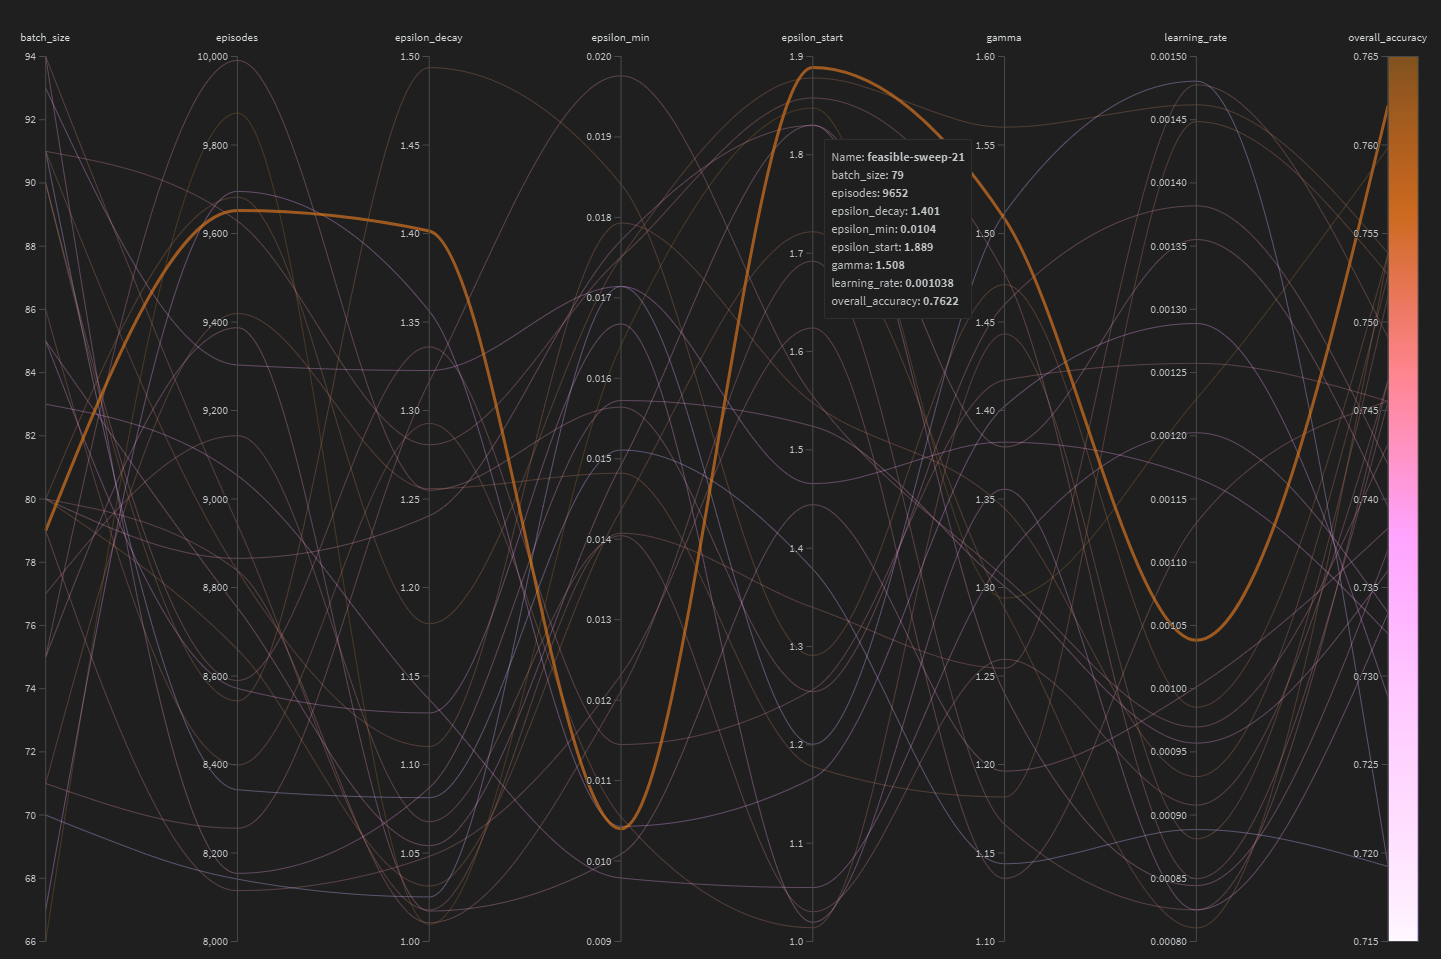

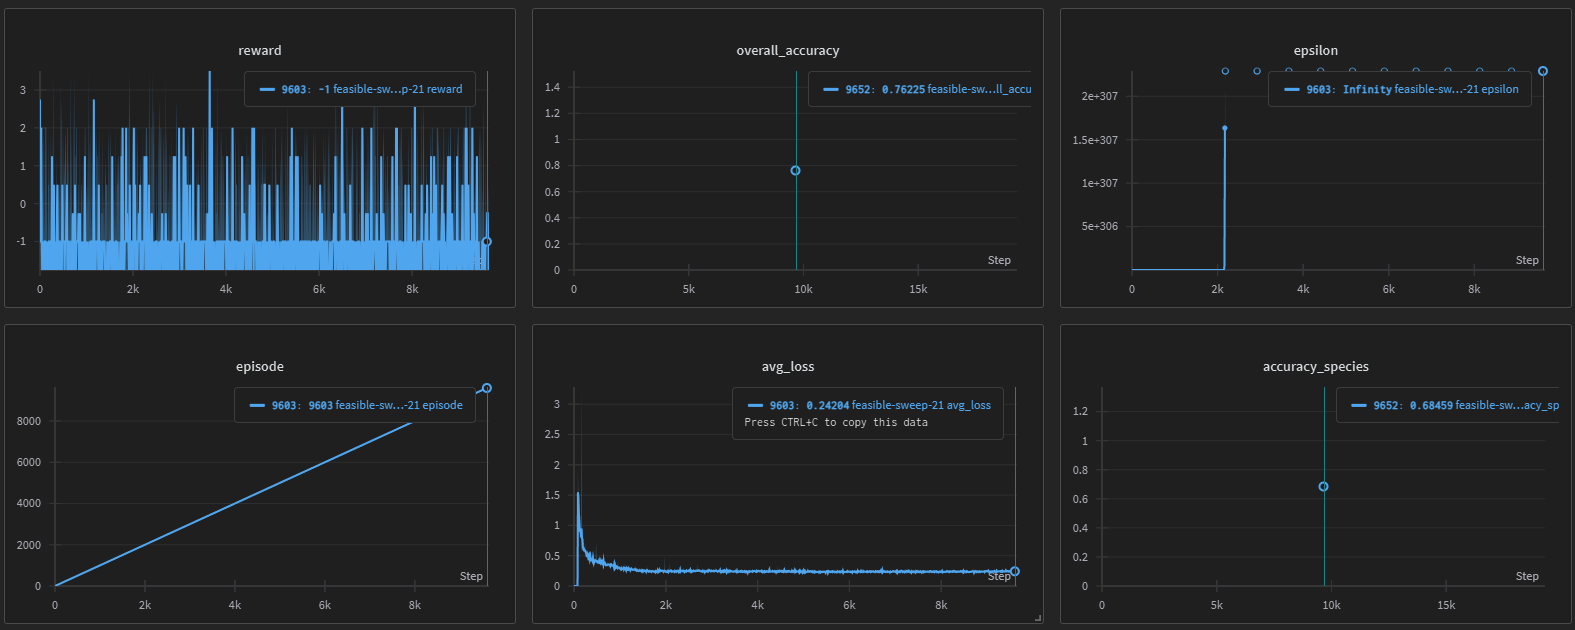

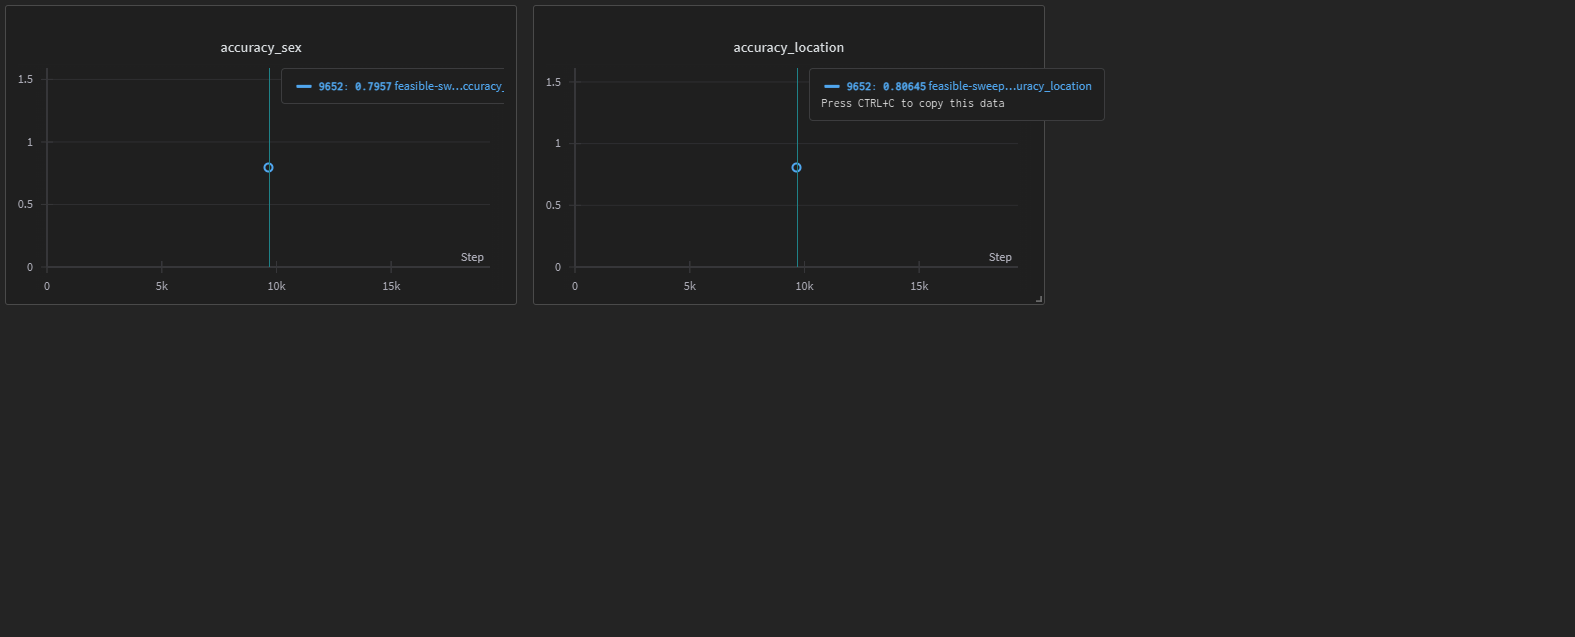

## 8. Model Saving

In [ ]:
# Save the trained model (only saving the main model)
# torch.save(rl_agent.model.state_dict(), "pipefishes_rl_model2.pth")

In [12]:
# Recreate the network (or agent) with the same architecture
new_agent = SeahorseRLAgent(data)  # data or its parameters must be the same for consistent scaling, etc.
new_agent.model.load_state_dict(torch.load("pipefishes_rl_model.pth"))
new_agent.model.eval()  # set the model to evaluation mode


C:\Users\Dipto\AppData\Local\Temp\ipykernel_47124\4274317558.py:58: RuntimeWarning: invalid value encountered in scalar divide
  pos_weight = torch.tensor([num_males / num_females], dtype=torch.float32).to(device)
C:\Users\Dipto\AppData\Local\Temp\ipykernel_47124\3008300151.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for

MultiHeadDQN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (species_head): Linear(in_features=32, out_features=17, bias=True)
  (location_head): Linear(in_features=32, out_features=15, bias=True)
  (sex_head): Linear(in_features=32, out_features=2, bias=True)
)

## 9. Interactive Output

In [ ]:
import numpy as np
import folium
from geopy.geocoders import Nominatim
from IPython.display import display  # Required for Jupyter or Colab

In [ ]:
def interactive_prediction_with_map(agent):
    try:
        length = float(input("Enter Length: "))
        brain_weight = float(input("Enter Brain Weight: "))
        user_input = np.array([[length, brain_weight]])

        prediction = agent.predict(user_input)
        species, location, sex = prediction
        print("Input (Length, Brain Weight):", user_input)
        print("Prediction (Species, Location, Sex):", prediction)

        # Geocode location
        geolocator = Nominatim(user_agent="pipefish-predictor")
        geocoded_location = geolocator.geocode(location)

        if geocoded_location:
            lat, lon = geocoded_location.latitude, geocoded_location.longitude

            # Create map with popup that includes the location name in English
            m = folium.Map(location=[lat, lon], zoom_start=6)
            popup_text = (
                f"<b>Species:</b> {species}<br>"
                f"<b>Location:</b> {location}<br>"
                f"<b>Sex:</b> {sex}"
            )
            folium.Marker(
                [lat, lon],
                popup=popup_text
            ).add_to(m)

            # ✅ Display inline (works in Jupyter/Colab)
            display(m)
        else:
            print(f"Could not geocode location: {location}")

    except Exception as e:
        print("Error:", e)

# Example usage
interactive_prediction_with_map(new_agent)


Input (Length, Brain Weight): [[321.7  10.7]]
Prediction (Species, Location, Sex): ('Formalin Preservation', 'Sweden', 'Female')
